# TERM PAPER TEAM DVD TECH-2

## PART 1 - reading in the data


In [354]:
#importing all the libraries needed for the tasks.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### TASK 1

In [355]:
#reading in the data 
DATA_PATH = 'data'
data = []
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ['2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']
for year in years:
    for month in months:
        try:
            filename = f'{DATA_PATH}/SCE-{month}-{year}.csv'
            df = pd.read_csv(filename,sep=';')
            data.append(df)
        except FileNotFoundError:
            # Error handelig since data is not present for all months in 2013
            continue

In [356]:
#merging all the dataframes in the data list into a single dataframe
df = pd.concat(data, ignore_index=True)

### TASK 2

In [357]:
# 2.1 number of unique individuals in the dataset
def num_unique_id():
    return len(df['userid'].unique())

print(f'Number of unique individuals in the dataset: {num_unique_id()}')

Number of unique individuals in the dataset: 23369


In [358]:
#2.2 number of rows in the dataset
def num_rows():
    return len(df)

print(f'Number of rows in the dataset: {num_rows()}')

Number of rows in the dataset: 176101


In [359]:
#2.3 number of unique survey waves
def unique_wid():
    return len(df['wid'].unique())

print(f'Number of unique survey waves: {unique_wid()}')

Number of unique survey waves: 139


In [360]:
#2.4 The first and last dates observed in the dataset.
first = df['date'].min()
print(f'First date observed in the dataset: {first}')
last = df['date'].max()
print(f'Last date observed in the dataset: {last}')

First date observed in the dataset: 2013-06-01
Last date observed in the dataset: 2024-12-31


## PART 2 - data pre-processing

### TASK 1

In [361]:
# Fill missing numeracy variables(num_lit_X_correct where X is a number)
num_cols = ['num_lit_q1_correct', 'num_lit_q2_correct', 'num_lit_q3_correct', 'num_lit_q5_correct', 'num_lit_q6_correct', 'num_lit_q8_correct', 'num_lit_q9_correct']

# Fill missing numeracy values with the first available non-missing value per user
# bfill() is used in case the first value is NaN, ensuring that a non-missing value is used to fill in columns backwards as well
for col in num_cols:
    df[col] = df.groupby('userid')[col].transform(lambda x: x.ffill().bfill())

### TASK 2

In [362]:
#2 drop all observationswith missing values
#1.for demographic variables(gender,age,education_level)
before = len(df)
df = df.dropna(subset=['female','age','educ'])
after_demographics = len(df)
print("Dropped demographics: ", before - after_demographics)

Dropped demographics:  868


In [363]:
#2.2  The three expectations questions about inflation, house price changes, and the stock market
#using the dropna function to drop rows with missing values in the specified columns
before = len(df)
df = df.dropna(subset=['inflation','house_price_change','prob_stocks_up'])
after_expectations = len(df)
print("Dropped expectations: ", before - after_expectations)

Dropped expectations:  1683


In [364]:
#2.3 The seven numeracy questions (after you have forward-filled nonmissing values in step 1!)
df = df.dropna(subset=num_cols)
after_numeracy = len(df)
print("Dropped demographics: ", after_expectations - after_numeracy)

Dropped demographics:  35974


### TASK 3

In [365]:
#3 Drop outliers (implausibly small or large values). For each expectations response:
expect_vars = ["inflation", "house_price_change", "prob_stocks_up"]
#creating a for loop to drop outliers for each variable in expect_vars
for var in expect_vars:
    low, high = df[var].quantile([0.001, 0.999])
    before = len(df)
    df = df[(df[var] >= low) & (df[var] <= high)]
    print(f"{var}: dropped {before - len(df)} outliers")

inflation: dropped 119 outliers
house_price_change: dropped 179 outliers
prob_stocks_up: dropped 0 outliers


### TASK 4

In [366]:
#Create a new column college equal to 1 if an individual has at least a bachelor’s degree, and 0
#otherwise.
df['college']=  (df["educ"] >= 4).astype(int)
df['college']

30936     1
30937     1
30942     1
30943     1
30944     1
         ..
176096    0
176097    1
176098    0
176099    0
176100    1
Name: college, Length: 137278, dtype: int64

### TASK 5

In [367]:
#total number of correct answers across the seven numeracy questions
df["num_correct"] = df[num_cols].sum(axis=1)
dist = df.groupby("num_correct")["userid"].nunique() / df["userid"].nunique()
print("\nDistribution of numeracy scores (% of individuals):")
print((dist * 100).round(1))

median_score = df["num_correct"].median()
df["num_lit_high"] = (df["num_correct"] > median_score).astype(int)


Distribution of numeracy scores (% of individuals):
num_correct
0.0     0.1
1.0     0.7
2.0     2.4
3.0     5.7
4.0    10.5
5.0    16.9
6.0    27.4
7.0    36.2
Name: userid, dtype: float64


### TASK 6

In [368]:
# Report the same sample statistics as in Part 1 for the final data set.
print(f'Number of unique individuals in the dataset: {num_unique_id()}')
print(f'Number of rows in the dataset: {num_rows()}')
print(f'Number of unique survey waves: {unique_wid()}')

Number of unique individuals in the dataset: 17701
Number of rows in the dataset: 137278
Number of unique survey waves: 117


## PART 3

### TASK 1 and TASK 2

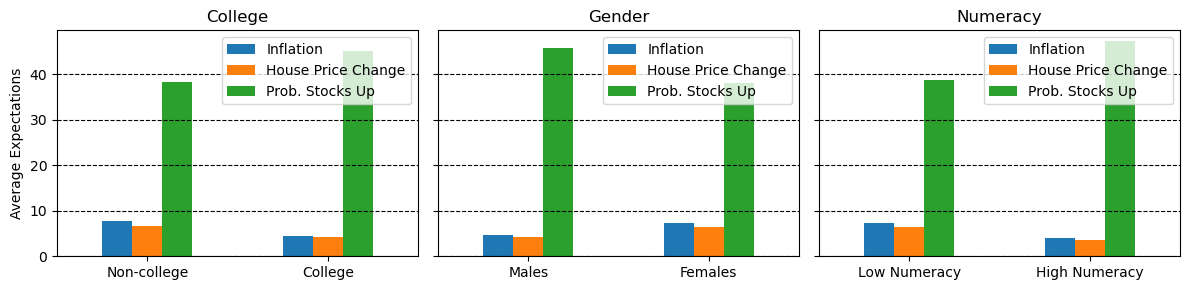

In [369]:
#Creating a list to analyze
groups = [
    ("college", {0: "Non-college", 1: "College"}, "College"),
    ("female", {0: "Males", 1: "Females"}, "Gender"),
    ("num_lit_high", {0: "Low Numeracy", 1: "High Numeracy"}, "Numeracy")
]

#Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

#Iterate through the list created and setting values for plotting
for ax, (column, mapping, title) in zip(axes, groups):
    group_means = df.groupby(column)[["inflation", "house_price_change", "prob_stocks_up"]].mean().reset_index()
    group_means[column] = group_means[column].map(mapping)

    Plotting_Values = group_means.set_index(column)

    #Plotting the graph 
    Plotting_Values.plot(kind = 'bar', ax= ax, legend = False)
    ax.set_title(title)
    ax.set_ylabel("Average Expectations")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    ax.set_xlabel("")
    ax.grid(True, axis="y", linestyle="--", alpha=1, color = 'black')
    ax.legend(["Inflation", "House Price Change", "Prob. Stocks Up"], loc='upper right')

fig.tight_layout()

# PART 4 Expectation dynamics by group

### TASK 1

In [370]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' is datetime
df['date'] = pd.to_datetime(df['date'])

# Restrict to 2015–2024
df_range = df[(df['date'].dt.year >= 2015) & (df['date'].dt.year <= 2024)]


### TASK 2 and TASK 3

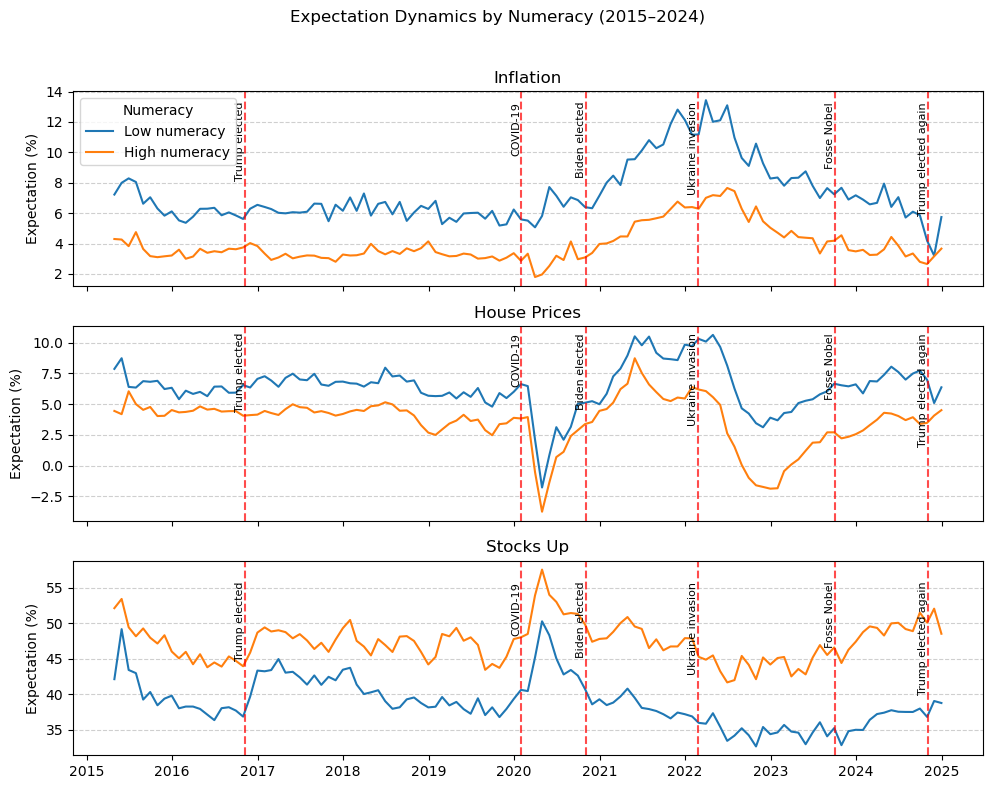

In [371]:
# Grouping variables to analyze

def create_data_frame_for_group(col, mapping, title):
    # Monthly averages by group
    monthly_avg = (
        df_range.groupby([pd.Grouper(key="date", freq="ME"), col])
        [["inflation", "house_price_change", "prob_stocks_up"]]
        .mean()
        .reset_index()
    )
    monthly_avg[col] = monthly_avg[col].map(mapping)
    return monthly_avg

groups = [
    ("female", {0: "Males", 1: "Females"}, "Gender"),
    ("college", {0: "Non-college", 1: "College"}, "Education"),
    ("num_lit_high", {0: "Low numeracy", 1: "High numeracy"}, "Numeracy")
]

for col, mapping, title in groups:
    monthly = create_data_frame_for_group(col, mapping, title)

fig, axes = plt.subplots(3, 1, figsize =(10, 8), sharex=True)

vars_ = ["inflation", "house_price_change", "prob_stocks_up"]
labels = ["Inflation", "House Prices", "Stocks Up"]

events = [
    ("2016-11-08", "Trump elected"),
    ("2020-02-01", "COVID-19"),
    ("2020-11-03", "Biden elected"),
    ("2022-02-24", "Ukraine invasion"),
    ("2023-10-03", "Fosse Nobel"),
    ("2024-11-05", "Trump elected again")
]

for ax, var, label in zip(axes, vars_, labels):
        for g in monthly[col].unique():
            subset = monthly[monthly[col] == g]
            ax.plot(subset["date"], subset[var], label=g)
        ax.set_title(label)
        ax.set_ylabel("Expectation (%)")
        ax.grid(True, axis="y", linestyle="--", alpha=0.6)

        # Add event markers
        for d, txt in events:
            ax.axvline(pd.to_datetime(d), color="red", linestyle="--", alpha=0.7)
            ax.text(pd.to_datetime(d), ax.get_ylim()[1]*0.95, txt,
                    rotation=90, va="top", ha="right", fontsize=8)

axes[0].legend(title=title)
plt.suptitle(f"Expectation Dynamics by {title} (2015–2024)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

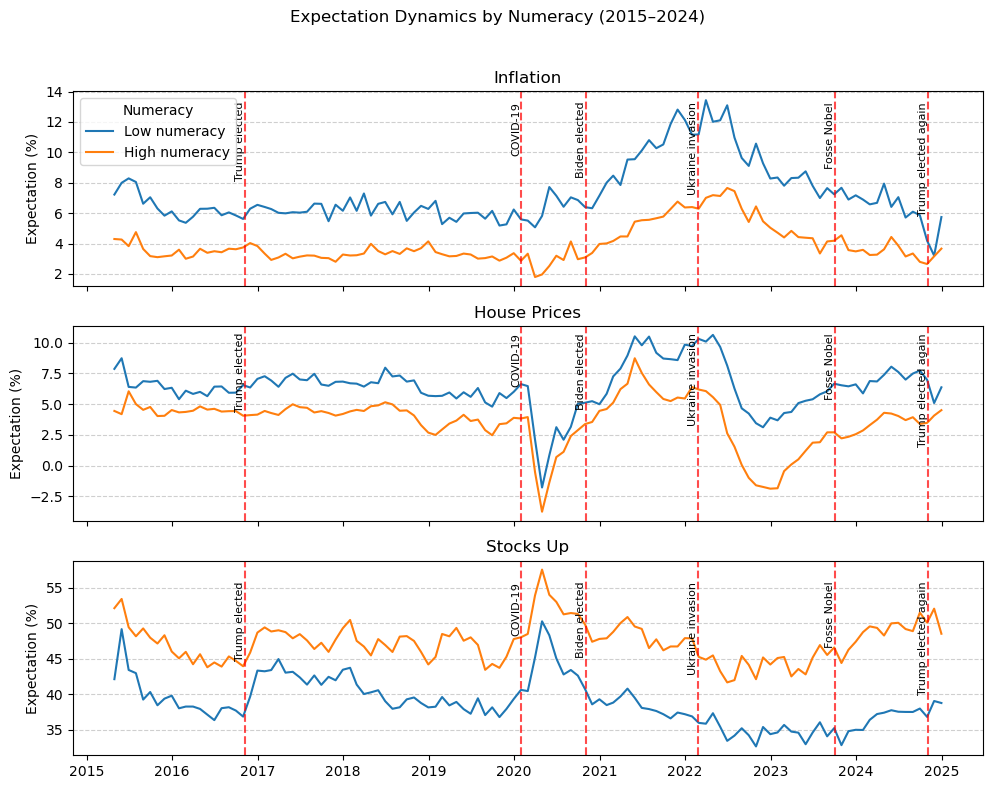

In [372]:
fig, axes = plt.subplots(3, 1, figsize =(10, 8), sharex=True)

vars_ = ["inflation", "house_price_change", "prob_stocks_up"]
labels = ["Inflation", "House Prices", "Stocks Up"]

events = [
    ("2016-11-08", "Trump elected"),
    ("2020-02-01", "COVID-19"),
    ("2020-11-03", "Biden elected"),
    ("2022-02-24", "Ukraine invasion"),
    ("2023-10-03", "Fosse Nobel"),
    ("2024-11-05", "Trump elected again")
]

for ax, var, label in zip(axes, vars_, labels):
        for g in monthly[col].unique():
            subset = monthly[monthly[col] == g]
            ax.plot(subset["date"], subset[var], label=g)
        ax.set_title(label)
        ax.set_ylabel("Expectation (%)")
        ax.grid(True, axis="y", linestyle="--", alpha=0.6)

        # Add event markers
        for d, txt in events:
            ax.axvline(pd.to_datetime(d), color="red", linestyle="--", alpha=0.7)
            ax.text(pd.to_datetime(d), ax.get_ylim()[1]*0.95, txt,
                    rotation=90, va="top", ha="right", fontsize=8)

axes[0].legend(title=title)
plt.suptitle(f"Expectation Dynamics by {title} (2015–2024)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# PART 5 Correlations with past and future realizations

#### Explanation

In [390]:
# Reading in the CPI data
filename = f'{DATA_PATH}/CPI.csv'
cpi_df = pd.read_csv(filename)

### TASK 1

In [392]:
#1.1 Inflation

def compute_looking_inflation(column_name, n):
    cpi_df[column_name] = (cpi_df['CPI'].shift(n) / cpi_df['CPI'] - 1) * 100
    return cpi_df

forward_cpi = compute_looking_inflation('realized_inflation_12m', n = -12)

forward_cpi.head()

,DATE,CPI,realized_inflation_12m
0,1947-01-01,21.5,10.232558
1,1947-02-01,21.6,9.722222
2,1947-03-01,22.0,6.818182
3,1947-04-01,22.0,8.181818
4,1947-05-01,22.0,9.090909


In [375]:
#1.2 Merge this inflation measure with the monthly averages by gender based on 
# match the average expected inflation by gender i in month t from the SCE, ExpIn f lationit,
# with the forward-looking inflation measure In f lationt from the CPI data

monthly.tail()

#Changing the name of the column to lowercase so that we can merge the columns
cpi_df = cpi_df.rename(columns={'DATE': 'date'})

def merge_with_CPI(cpi_df, monthly_avg_df, columns):
    #Make sure that the data types are the same
    monthly_avg_df['date'] = pd.to_datetime(monthly_avg_df['date'])
    cpi_df['date'] = pd.to_datetime(cpi_df['date'])
    
    #Convert to month periods since cpi has dates with the first day (1st) of the month
    #while our monthly df has dates with the last day (30th or 31st) of the month
    monthly_avg_df['month'] = monthly_avg_df['date'].dt.to_period('M')
    cpi_df['month'] = cpi_df['date'].dt.to_period('M')
    
    # Merge: keep all rows from sce_df, match on month
    monthly_cpi_df = pd.merge(
        monthly_avg_df[columns],
        cpi_df[['month','CPI', 'realized_inflation_12m']],
        on='month',
        how='inner'   # <-- only months from SCE data are kept
    )
    return monthly_cpi_df


numeracy_monthly_cpi_df = merge_with_CPI(cpi_df, monthly,['month','num_lit_high', 'house_price_change', 'prob_stocks_up'])
numeracy_monthly_cpi_df.head()

,month,num_lit_high,house_price_change,prob_stocks_up,CPI,realized_inflation_12m
0,2015-04,Low numeracy,7.860000,42.150000,236.2,1.185436
1,2015-04,High numeracy,4.446429,52.142857,236.2,1.185436
2,2015-05,Low numeracy,8.727273,49.188312,237.0,1.097046
3,2015-05,High numeracy,4.185000,53.440000,237.0,1.097046
4,2015-06,Low numeracy,6.399061,43.446009,237.7,1.051746


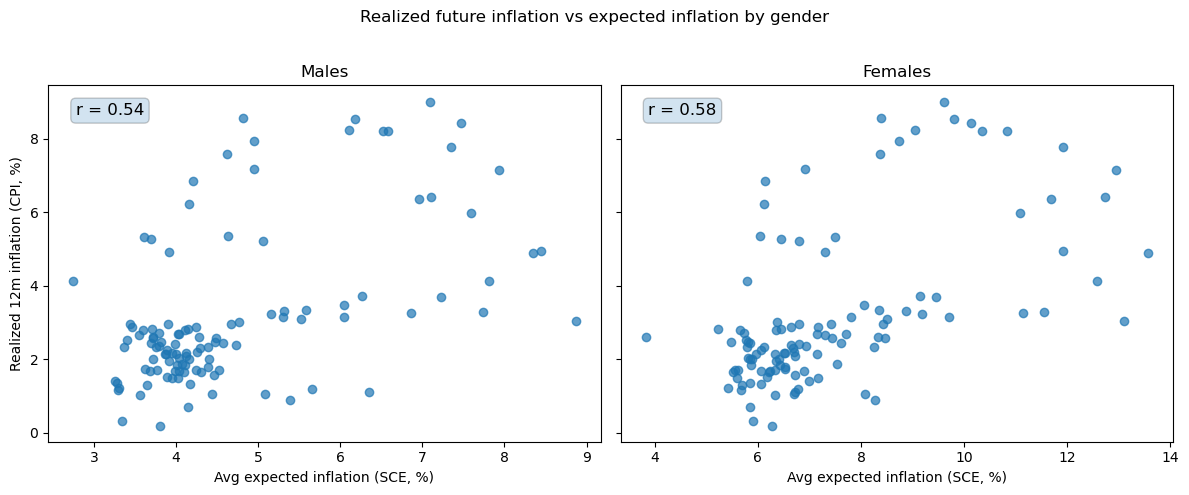

In [379]:
#1.3 Creating a scatter plot
(('female', {0: 'Males', 1: 'Females'}, 'Gender'),)
gender_monthly_avg = create_data_frame_for_group('female', {0: 'Males', 1: 'Females'}, 'Gender')

gender_monthly_cpi_df = merge_with_CPI(cpi_df, gender_monthly_avg, ['month', 'house_price_change', 'prob_stocks_up','female','inflation'])
gender_monthly_cpi_df.head()

# Scatter: realized future inflation vs avg expected inflation by gender
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
genders = ['Males', 'Females']

for ax, g in zip(axes, genders):
    sub = gender_monthly_cpi_df[gender_monthly_cpi_df['female'] == g].dropna(subset=['inflation', 'realized_inflation_12m'])
    ax.scatter(sub['inflation'], sub['realized_inflation_12m'], alpha=0.7)
    # correlation
    if len(sub) >= 2:
        r = sub['inflation'].corr(sub['realized_inflation_12m'])
        corr_text = f"r = {r:.2f}"
    else:
        corr_text = "r = n/a"
    ax.text(0.05, 0.95, corr_text, transform=ax.transAxes, va='top', ha='left',
            fontsize=12, bbox=dict(boxstyle='round', alpha=0.2))
    ax.set_title(g)
    ax.set_xlabel("Avg expected inflation (SCE, %)")
axes[0].set_ylabel("Realized 12m inflation (CPI, %)")
plt.suptitle("Realized future inflation vs expected inflation by gender")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### TASK 2

In [ ]:
compute_looking_inflation('realized_inflation_past_12m', n = 12)



,DATE,CPI,realized_inflation_12m,realized_inflation_past_12m
939,2025-04-01,320.3,NaN,-2.279113
940,2025-05-01,320.6,NaN,-2.339364
941,2025-06-01,321.5,NaN,-2.612753
942,2025-07-01,322.1,NaN,-2.638932
943,2025-08-01,323.4,NaN,-2.875696


Males: corr(expected, future realized) = 0.54, corr(expected, past realized) = 0.81
Females: corr(expected, future realized) = 0.58, corr(expected, past realized) = 0.83


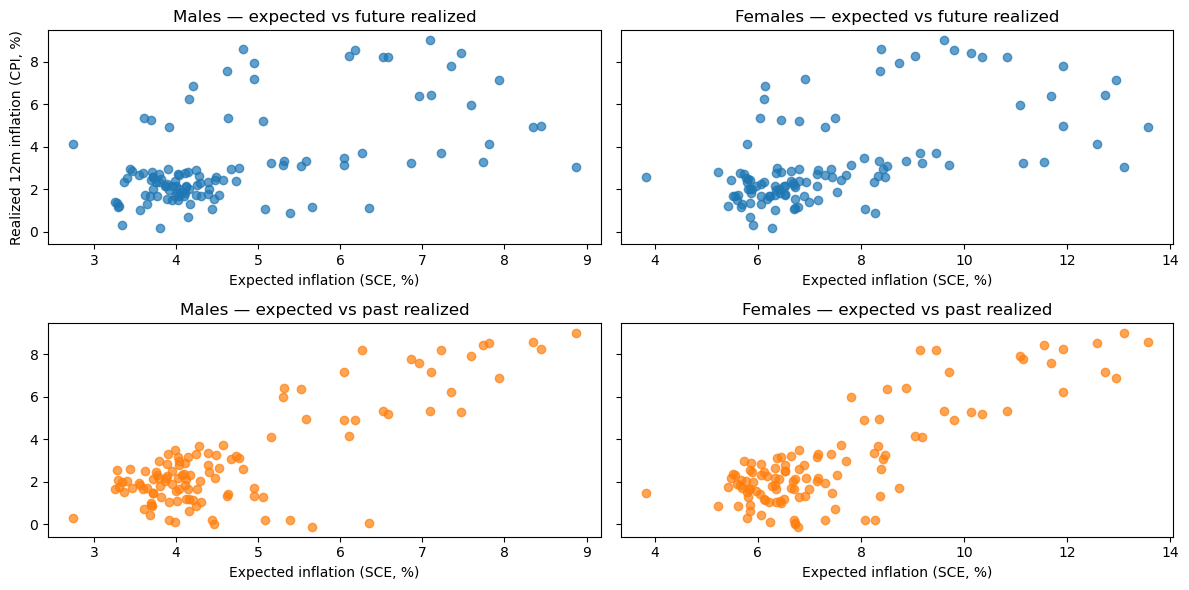

In [ ]:
cpi_df['realized_inflation_past_12m'] = (cpi_df['CPI'] / cpi_df['CPI'].shift(12) - 1) * 100# compute realized past 12-month inflation (CPI_t / CPI_{t-12} - 1)


# merge monthly (gender) averages with both forward- and backward-looking realized inflation
merged = monthly_gender.merge(
    cpi_df[['month', 'realized_inflation_12m', 'realized_inflation_past_12m']],
    on='month',
    how='inner'
)

# save merges for later use
merged_future = merged[['female', 'inflation', 'realized_inflation_12m']].copy()
merged_past = merged[['female', 'inflation', 'realized_inflation_past_12m']].copy()

# compute and print correlations by gender (expected vs future realized, and expected vs past realized)
genders = merged['female'].unique()
for g in genders:
    sub = merged[merged['female'] == g].dropna(
        subset=['inflation', 'realized_inflation_12m', 'realized_inflation_past_12m']
    )
    corr_future = sub['inflation'].corr(sub['realized_inflation_12m'])
    corr_past = sub['inflation'].corr(sub['realized_inflation_past_12m'])
    print(f"{g}: corr(expected, future realized) = {corr_future:.2f}, corr(expected, past realized) = {corr_past:.2f}")

# Quick visual check: scatter plots (future vs past) side-by-side for each gender
fig, axes = plt.subplots(2, len(genders), figsize=(12, 6), sharey=True)
for i, g in enumerate(genders):
    sub = merged[merged['female'] == g].dropna(
        subset=['inflation', 'realized_inflation_12m', 'realized_inflation_past_12m']
    )
    axes[0, i].scatter(sub['inflation'], sub['realized_inflation_12m'], alpha=0.7)
    axes[0, i].set_title(f"{g} — expected vs future realized")
    axes[0, i].set_xlabel("Expected inflation (SCE, %)")
    if i == 0:
        axes[0, i].set_ylabel("Realized 12m inflation (CPI, %)")

    axes[1, i].scatter(sub['inflation'], sub['realized_inflation_past_12m'], alpha=0.7, color='tab:orange')
    axes[1, i].set_title(f"{g} — expected vs past realized")
    axes[1, i].set_xlabel("Expected inflation (SCE, %)")

plt.tight_layout()
plt.show()
